### <p style="background-color:#627D50;color:#D1CABD;font-size:110%;text-align:center;border-radius:20px 60px;  border: 10px solid #cfcfcf;  padding-top: 10px;  padding-left: 10px;  padding-right: 10px; padding-bottom: 10px;  border-radius: 80px 20px;line-height: 1.2em; margin-bottom: 10px;"> **Projet 4** : Anticipez les besoins en consommation de bâtiments </p>

<img src="seattle.png" align="left" alt="Alternative text" />

Vous travaillez pour la ville de **Seattle**. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s'intéresse de près à la consommation et aux émissions des bâtiments non destinés à l'habitation.

---
- Mentor [**Babou M'BAYE**]()
- Etudiant [**Bourama FANE**](https://www.linkedin.com/in/bourama-fan%C3%A9-7aba41141/)
- Parcours [*Data Scientiste*]()
- Ecole [*OpenClassrooms*]()

---

## <a id='-1'> <font color='#114b98' font-size='100%' text-align='left'> Sommaire </font> </a>
----------

[<font color="#337da4"> <h5> 1. Data Preprocessing](#1)</h5>
>[1.1 Encodage](#1.1)<br>
>[1.2 Transformation des target](#1.2)<br>
>[1.3 feature scaling](#1.3)<br>
>[1.4 Split du data set](#1.4)
    
[<font color="#337da4"> <h5> 2. Modélisation linéaire](#2)</h5>
> [2.1 Baseline](#2.1)<br>
> [2.2 Regression Ridge / Lasso / Elastic Net](#2.2)<br>
> [2.3 Modèle Support Vector Regression (SVR)](#2.3)
    
[<font color="#337da4"> <h5> 3. Modèles non-linéaires](#3)</h5>
> [3.1. Modèle RandomForestRegressor](#3.1)<br>
> [3.2. Modèle XGBoost *(eXtreme Gradient Boosting)*](#3.2)<br>
> [3.3. Support Vector Regression - SVR NON Linéaire polynomiale](#3.3)<br>
> [3.4 K-NN regressor](#3.4)
    
[<font color="#337da4"> <h5> 4. Selection du meilleur modèle ](#4)</h5>     
> [4.1. Meilleur modèle de prédiction](#4.1)<br>
> [4.2. GridSearchCV sur le meilleur modèle](#4.2)<br>
> [4.3. Features importance](#4.3)<br>
> [4.4. Analyse des résidus](#4.4)
    
[<font color="#337da4"> <h5> 5. Influence du score ENERGY STAR](#5)</h5>
[<font color="#337da4"> <h5> 6. Conclusion](#6)</h5>

## <a id='1'> <font color="#114b98"> 1- Librairies & Fonctions  </a>
-----------
[Back to table of content](#-1) <br>

#### Importation des librairies 

In [1]:
import os
from datetime import date
from datetime import time
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
import missingno as msno
from pivottablejs import pivot_ui
from IPython.display import HTML
from pandas_profiling import ProfileReport
from IPython.display import display, Markdown
from matplotlib.lines import Line2D

plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)
# import warnings
# warnings.filterwarnings('ignore')

# Affichage des valeurs
pd.set_option('display.max_colwidth', None)

# !pip install dataframe_to_image
import dataframe_image as dfi
imgPath='D:/OpenClassrooms/Projet 4/Soutenance/'

font_title = {'family': 'serif','color':  '#114b98','weight': 'bold','size': 16,}

font_title2 = {'family': 'serif', 'color':  '#114b98','weight': 'bold', 'size': 12,}

mycolors = ["black", "hotpink", "b", "#4CAF50"]
AllColors=['#99ff99','#66b3ff','#4F6272', '#B7C3F3','#ff9999','#ffcc99','#ff6666', '#DD7596', '#8EB897',
           '#c2c2f0','#DDA0DD','#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', 
           '#7f7f7f', '#bcbd22', '#17becf','#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33',
           '#a65628','#f781bf',"#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7", "#000000"]

%matplotlib inline

### Fonctions 

In [2]:
def namestr(obj, namespace):
    ''' fonction retourne le nom en string '''
    return [name for name in namespace if namespace[name] is obj] 

def Camembert(data,col):
    df = data[col].value_counts().reset_index()
    L=len(df[col])
    labels=list(df['index'])
    sizes=list(df[col])
    # print(labels,"\n",sizes)
    explode = Explodetuple(L)
    colors =AllColors[:L] 
    fig1, ax1 = plt.subplots(figsize=(7, 5))
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',shadow=True, startangle=0) 
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    plt.tight_layout()
    plt.show()
    
def remplacement(data, cols, caracter1,caracter2):
    for col in cols:
        data[col] = data[col].str.lower().str.replace(caracter1, caracter2)
    return data

def remplacement2(data, cols, caracter1,caracter2):
    for col in cols:
        data[col] = data[col].str.replace(caracter1, caracter2)
    return data

def recodage(data, cols):
    for col in cols:
        data[col] = np.where((data[col].isnull()==True), "unknown", np.where(data[col] == "", "unknown", data[col]))
    return data

# Cette fonction permet de lister les modalités avec leur occurence d'unchamp qui cumule differentes modalités.
def top_words(data, cols, nb_top=1000):
    count_keyword = dict()
    for index, col in data[cols].iteritems():
        if isinstance(col, float):
            continue
        for word in col.split(','):
            if word in count_keyword.keys():
                count_keyword[word] += 1
            else :
                count_keyword[word] = 1
  
    keyword_top = []
    for k,v in count_keyword.items():
        keyword_top.append([k,v])
    keyword_top.sort(key = lambda x:x[1], reverse = True)
    return keyword_top[:nb_top]


def Explodetuple(m):
    liste1=[]
    for t in range(m):
        if t in [0,1] :
            liste1.append(0.1)
        else:
            liste1.append(0)
    return tuple(liste1) 

def percentFreq(values):
    def my_format(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        # return '{:.1f}%\n({v:d})'.format(pct, v=val)
        return '{:.1f}%({v:d})'.format(pct, v=val)
    return my_format
    

def repartitionTypeVar(data,figsize=(6, 3),title="Repartition par types de variables \n",graphName=''):
    df = data.dtypes.value_counts()
    L=len(df)
    labels=list(df.index)
    sizes=list(df)
    # print(labels,"\n",sizes)
    explode = Explodetuple(L)
    colors =AllColors[:L] 
    fig1, ax1 = plt.subplots(figsize=figsize)
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct=percentFreq(df),shadow=True, startangle=0) 
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax1.axis('equal')
    plt.tight_layout()
    plt.title(label=title,fontdict=font_title)
    plt.legend()
    if graphName!='':
        plt.savefig(imgPath+graphName, bbox_inches='tight')  
    plt.show() 
    plt.close()
    df=df.reset_index()
    df.columns=['Types de variables','Nombre']
    display(df.reset_index(drop=True))

import pandas as pd
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def nuageMots(data, col,figsize=(16,12),color="white",graphName=''):
    display(Markdown('------------------------------------'))       
    display(Markdown('#### Nuage de mots sur : {0}'.format(col)))
    display(Markdown('------------------------------------'))
    fig = plt.figure(1, figsize=figsize)
    ax1 = fig.add_subplot(1,1,1)
    #Creation de la variable text
    df=data.loc[data[col].notnull(),:]
    text = ' '.join(cat for cat in df[col])
    # Carte avec les mots: background_color="salmon"
    word_cloud = WordCloud(width=2000,height=1000,normalize_plurals=False,random_state=1,# colormap="Pastel1", 
                           collocations=False,stopwords=STOPWORDS, background_color=color, ).generate(text)
    ax1.imshow(word_cloud, interpolation="bilinear")
    # Afficher le nuage
    plt.imshow(word_cloud)
    plt.axis("off")
    if graphName!='':
        plt.savefig(imgPath+graphName, bbox_inches='tight')
    plt.show()
    plt.close()
    
def freqSimple (data, cols):
    return data[cols].unique().tolist()

def valeurUnique(data, cols):
    return data.drop_duplicates(subset=cols)[cols]


def freqSimple2(data, col_names):
    for col_name in col_names:    
        effectifs = data[col_name].value_counts()
        modalites = effectifs.index # l'index de effectifs contient les modalités
        tab = pd.DataFrame(modalites, columns = [col_name]) # création du tableau à partir des modalités
        tab["Nombre"] = effectifs.values
        tab["Frequence"] = tab["Nombre"] / len(data) # len(data) renvoie la taille de l'échantillon
        # tab = tab.sort_values(col_name) # tri des valeurs de la variable X (croissant)
        tab["Freq. cumul"] = tab["Frequence"].cumsum() # cumsum calcule la somme cumulée
        display(Markdown('------------------------------------'))       
        display(Markdown('#### Fréquence sur la variable ***' + col_name+'***'))
        display(Markdown('------------------------------------'))
        display(tab)
        
        
def selectionVar(data, typevar=['object']):
    ''' Cette fonction récupère dans la base en entrée toutes les variables
    qui ayant le type typevar spécifié comme argument '''
    listVar=list(data.select_dtypes(include=typevar).columns)
    return listVar

In [3]:
dfBuild = pd.read_csv('dfBuild.csv')
dfBuild.head()

,BuildingType,PrimaryPropertyType,PropertyName,Address,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,...,BuildAgeGroup,FE_SteamUse,FE_Electricity,FE_NaturalGas,FE_NumberOfUseType,FE_PartLargestUseGFA,FE_PartGFABuilding,FE_PartGFAParking,FE_GFAPerBuilding,FE_GFAPerFloor
0,NonResidential,Hotel,MAYFLOWER PARK HOTEL,405 Olive way,7,DOWNTOWN,47.61220,-122.33799,1927,1,...,"(80, 90]",1.0,1.0,1.0,1,1.000000,1.00000,0.00000,88434.0,7369.50
1,NonResidential,Hotel,PARAMOUNT HOTEL,724 Pine street,7,DOWNTOWN,47.61317,-122.33393,1996,1,...,"(10, 20]",0.0,1.0,1.0,3,0.809918,0.85455,0.14545,103566.0,9415.09
2,NonResidential,Hotel,5673-THE WESTIN SEATTLE,1900 5th Avenue,7,DOWNTOWN,47.61393,-122.33810,1969,1,...,"(40, 50]",1.0,1.0,1.0,1,0.791220,0.79425,0.20575,956110.0,23319.76
3,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,7,DOWNTOWN,47.61412,-122.33664,1926,1,...,"(80, 90]",1.0,1.0,1.0,1,1.000000,1.00000,0.00000,61320.0,6132.00
4,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,7,DOWNTOWN,47.61375,-122.34047,1980,1,...,"(30, 40]",0.0,1.0,1.0,3,0.703070,0.64688,0.35312,175580.0,9754.44


In [4]:
dfBuild.columns
listVar=['TotalGHGEmissions','SiteEnergyUse(kBtu)', 'BuildingType', 'PrimaryPropertyType', 'Neighborhood', 'Latitude', 'Longitude', 'PropertyGFATotal',
         'ENERGYSTARScore',  'SiteEnergyUse(kBtu)', 'TotalGHGEmissions',  'BuildAgeGroup', 'FE_SteamUse', 'FE_Electricity',
         'FE_NaturalGas', 'FE_NumberOfUseType', 'FE_PartLargestUseGFA', 'FE_PartGFABuilding', 'FE_PartGFAParking', 
         'FE_GFAPerBuilding','FE_GFAPerFloor']

### <font color="#337da4" id="1">1. Data Preprocessing</font>
----------------------
<details>
<summary><font color="#2cb7b0"><b> Commentaires :</b></font></summary> <br>
<h5>Définition</h5>
    
La préparation de données ou le data preprocessing ou le pré-traitement est un processus qui précède celui de l'analyse de données. Il est constitué de plusieurs tâches comme le nettoyage de données, l'encodage, la normalisation, le split des données, etc.

Au cours du data preprocessing, les données dites « brutes » sont soumises à différents traitements afin de les rendre exploitables pour l'étape de la construction de modèles.
<h5>Importance </h5>
Le data preprocessing est une étape clé car la fiabilité de l'analyse des données (résultats des modèles) dépend en très grande partie de la qualité des données.
</details>

#### <font color="#337da4" id="1.1">1.1 Encodage </font>
<details>
<summary><font color="#2cb7b0"><b> Commentaires :</b></font></summary> <br>


Comme le modèle d'apprentissage automatique ne peut pas traiter les données catégorielles doivent être recodées sous forme de valeurs numériques pour être intégrés aux modèles de machine learning. Cela peut être fait de plusieurs manières :

**_LabelEncoder_:** transforme un vecteur **["a","b","c"]** en vecteur numérique **[0,1,2]**. Cette approche a l'inconvénient d'introduire un ordre dans les modalités, ce qui n'est pas toujours souhaitable

**_OrdinalEncoder_:** une version généralisée du LabelEncoder qui a vocation à s'appliquer sur des matrices ($X$), alors que LabelEncoder s'applique plutôt à un vecteur ($y$)

_**pandas.get_dummies**_ : effectue une opération de dummy expansion. Un vecteur de taille $n$ avec $K$ catégories sera transformé en matrice de taille $n$x$K$ pour lequel chaque colonne sera une variable dummy pour la modalité **k**. Il y a ici modalités et il y a donc multicolinéarité. Avec une régression linéaire avec constante, il convient de retirer une modalité avant l'estimation.

**_OneHotEncoder_:** est une version généralisée (et optimisée) de la ***dummy expansion***. Il a plutôt vocation à s'appliquer sur les features ($X$) du modèle.
</details>

In [5]:
# Variables qualitatives à encoder
quali_features =['BuildingType', 'PrimaryPropertyType', 'Neighborhood']

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

# encodage
df = pd.get_dummies(dfBuild[quali_features])
dfBuild2=pd.concat([dfBuild,df], axis=1)
dfBuild2=dfBuild
# Pour les variables Ordinales
ordinal_features =['BuildAgeGroup']
ordinal = OrdinalEncoder()
dfBuild[ordinal_features] = ordinal.fit_transform(dfBuild[ordinal_features])
dfBuild.drop(quali_features,axis=1, inplace=True)
dfBuild[['BuildAgeGroup']].head()

,BuildAgeGroup
0,10.0
1,1.0
2,6.0
3,10.0
4,5.0


#### <font color="#337da4" id="1.2">1.2 Transformation des targets </font>

Concernant nos variables à prédire, nous allons regarder l'impact du passage à l'échelle logarithmique sur les distribution

In [6]:
dfBuild['CO2_log'] = np.log(dfBuild['TotalGHGEmissions'])
dfBuild['Energy_log'] = np.log(dfBuild['SiteEnergyUse(kBtu)'])

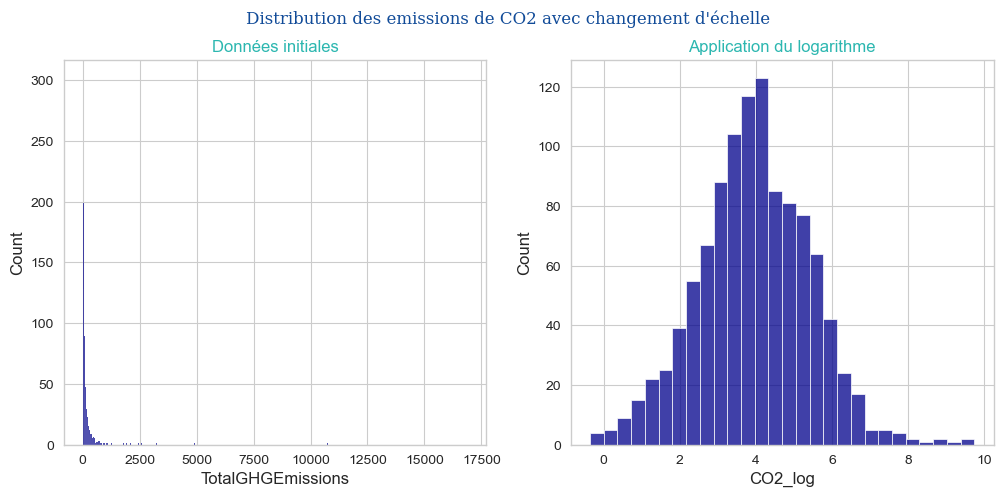

In [7]:
def CompareLog(data,target, targetLog,title='',figsize=(12,5)):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
    sns.histplot(data=data, x=target,color='darkblue',  ax=axes[0]) # stat="density",
    axes[0].set_title("Données initiales", color='#2cb7b0',size=12)
    sns.histplot(data=data, x=targetLog,  ax=axes[1],color='darkblue') # stat="density",
    axes[1].set_title("Application du logarithme", color='#2cb7b0',size=12)
    plt.suptitle(title, fontdict=font_title)
    plt.show()
    
CompareLog(dfBuild,'TotalGHGEmissions','CO2_log', title="Distribution des emissions de CO2 avec changement d'échelle  \n")

----
En appliquant le log aux variables d'interêts, les distributions ressemblent à des distributions normales. Nous allons donc, retenir ces variables en logarithme pour la suite des analyses.  

#### <font color="#337da4" id="1.3">1.3 Feature scaling </font>

<details>
<summary><font color="blue"><b> Note </b></font></summary>
Quand les données d'un Data Set sont dans des ordres de grandeurs différents, certains algorithmes de Machine Learning mettent plus de temps à trouver un modèle prédictif optimal.

Le Feature Scaling  est une bonne pratique, pour ne pas dire obligatoire, lors de la modélisation avec du Machine Learning.
Les algorithmes pour lesquels le feature scaling s'avère nécessaire, sont ceux pour lesquels il faudra:

- Calculer un vecteur de poids (weights) theta
- Calculer des distances pour déduire le degrée de similarité de deux items
- Certains algorithmes de Clustering

Plus concrétement, voici une liste d'algorithmes non exhaustive pour lesquels il faudra procéder au Feature Scaling :

- Logistic Regression
- Regression Analysis (polynomial, multivariate regression…)
- Support Vector Machines (SVM)
- K-Nearest Neighbors (KNN)
- K-Means (clustering…)
- Principal Component Analysis (PCA)

Parmi les techniques du feature scaling, on retrouve la **Standardisation** et la **Normalisation**. 
</details>

In [8]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler,scale

numeric_features=['Latitude','Longitude', 'PropertyGFATotal', 'ENERGYSTARScore', 'BuildAgeGroup','FE_NumberOfUseType', 
                  'FE_PartLargestUseGFA', 'FE_PartGFABuilding', 'FE_PartGFAParking', 'FE_GFAPerBuilding','FE_GFAPerFloor']

dfBuild[numeric_features] = RobustScaler().fit_transform(dfBuild[numeric_features])
# from sklearn.preprocessing import StandardScaler
# data_log_transformed[numerical_columns] = StandardScaler().fit_transform(data_log_transformed[numerical_columns])
X_CO2=dfBuild[numeric_features]
X_Energy=dfBuild[numeric_features]
y_CO2=dfBuild[['CO2_log']]
y_Energy=dfBuild[['Energy_log']]

#### <font color="#337da4" id="1.4">1.4 Split du data set  </font>

Afin de tester notre meilleur modèle sur des données "inconnues", nous allons mettre de côté une partie des données initiales qui ne seront pas inclusent dans les modèles intermédiaires. Nous allons donc spliter nos données pour obtenir un jeu d'entrainement et un jeu de test (20% des données)

In [9]:
from sklearn import model_selection
from sklearn.model_selection import train_test_split

dfBuild=dfBuild[['CO2_log', 'Energy_log','TotalGHGEmissions','SiteEnergyUse(kBtu)', 'Latitude','Longitude', 'PropertyGFATotal', 'ENERGYSTARScore', 'BuildAgeGroup', 
                 'FE_SteamUse', 'FE_Electricity','FE_NaturalGas', 'FE_NumberOfUseType', 'FE_PartLargestUseGFA',
                 'FE_PartGFABuilding', 'FE_PartGFAParking', 'FE_GFAPerBuilding','FE_GFAPerFloor']]

features=['Latitude','Longitude', 'PropertyGFATotal', 'ENERGYSTARScore', 'BuildAgeGroup','FE_SteamUse', 'FE_Electricity',
          'FE_NaturalGas', 'FE_NumberOfUseType', 'FE_PartLargestUseGFA','FE_PartGFABuilding', 
          'FE_PartGFAParking', 'FE_GFAPerBuilding','FE_GFAPerFloor']

target='CO2_log' # 'Energy_log'
X_train_CO2, X_test_CO2, y_train_CO2, y_test_CO2 =train_test_split(dfBuild[features], 
                                                                   dfBuild[[target]], 
                                                                   test_size = 0.2, 
                                                                   random_state = 42)
X_train_CO2.shape, y_train_CO2.shape, X_test_CO2.shape, y_test_CO2.shape


((868, 14), (868, 1), (217, 14), (217, 1))

In [10]:
X_train_CO2_ESS=X_train_CO2[features]
X_test_CO2_ESS=X_test_CO2[features]

X_train_CO2=X_train_CO2[list(set(features)-set(['ENERGYSTARScore']))]
X_test_CO2=X_test_CO2[list(set(features)-set(['ENERGYSTARScore']))]

In [11]:
target='Energy_log' # 'CO2_log'
X_train_Energy, X_test_Energy, y_train_Energy, y_test_Energy = train_test_split(dfBuild[features], 
                                                                                dfBuild[[target]], 
                                                                                test_size = 0.2, 
                                                                                random_state = 42)
X_train_Energy.shape, y_train_Energy.shape, X_test_Energy.shape, y_test_Energy.shape

((868, 14), (868, 1), (217, 14), (217, 1))

In [12]:
X_train_Energy_ESS=X_train_Energy[features]
X_test_Energy_ESS=X_test_Energy[features]

X_train_Energy=X_train_Energy[list(set(features)-set('ENERGYSTARScore'))]
X_test_Energy=X_test_Energy[list(set(features)-set('ENERGYSTARScore'))]

### <font color="#337da4" id="2">2. Modélisation </font>
-----------
[Back to table of content](#-1) <br>

#### <font color="#337da4" id="2.1">2.1 Baseline : Modèle de de predictions </font>

A présent, nous allons créer un modèle baseline pour évaluer les performances de nos futurs modèles et vérifier qu'ils améliore les prédictions. Pour cette baseline, nous utiliserons une régression linéaire multivariée.

In [13]:
ListResults=[]

In [14]:
from sklearn.linear_model import LinearRegression
# creating a function to create adhusted R-Squared
def adj_r2(X, y, model):
    r2 = model.score(X, y)
    n = X.shape[0]
    p = X.shape[1]
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)    
    return adjusted_r2

def regression(X_train, y_train,X_test,y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    # prediction 
    y_pred = lr.predict(X_test)
    # score sur le training
    print('score sur le training :',lr.score(X_train, y_train))
    # score sur le test
    print('score sur le test :',lr.score(X_test, y_test))
    print('R2 Adjusté Train :', adj_r2(X_train, y_train, lr))
    print('R2 Adjusté test :', adj_r2(X_test, y_test, lr))

In [15]:
regression(X_train_Energy, y_train_Energy, X_test_Energy, y_test_Energy)

score sur le training : 0.6041646613425733
score sur le test : 0.5294021144907634
R2 Adjusté Train : 0.5976679500398723
R2 Adjusté test : 0.49678641945546964


In [16]:
regression(X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)

score sur le training : 0.5541719478751876
score sur le test : 0.4971113182576823
R2 Adjusté Train : 0.5473853381824212
R2 Adjusté test : 0.4649066243530019


In [17]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

# Créer un pipeline avec une régression linéaire
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

# Définir les paramètres pour la régression linéaire
parameters = {
    # 'regressor__scaler': [MinMaxScaler(), StandardScaler()],
    'regressor__fit_intercept': [True, False],
}

# Utiliser GridSearchCV pour trouver les meilleurs paramètres
grid_search = GridSearchCV(pipeline, parameters, cv=5)
grid_search.fit(X_CO2,y_CO2)
# Afficher les meilleurs paramètres et score
print("Meilleurs paramètres: ", grid_search.best_params_)
print("Score: ", grid_search.best_score_)
# 'CO2_log' # 'Energy_log'

Meilleurs paramètres:  {'regressor__fit_intercept': True}
Score:  0.06257091991284433


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Créer un objet LinearRegression
lr = LinearRegression()


# Définir les hyperparamètres à rechercher
param_grid = { 'fit_intercept': [True, False]} # 'normalize': [True, False],

# Créer un objet GridSearchCV
grid = GridSearchCV(lr, param_grid, cv=5)

# Entraîner le modèle GridSearchCV
grid.fit(X_train_CO2, y_train_CO2)

# Afficher les meilleurs paramètres et le meilleur score
print("Meilleurs paramètres : ", grid.best_params_)
print("Meilleur score GridSearchCV: ", grid.best_score_)
print("Meilleur score test : ", grid.score(X_test_CO2, y_test_CO2))   

# Entraîner un nouveau modèle avec les meilleurs paramètres sur toutes les données d'entraînement
lr_best = LinearRegression(**grid.best_params_)
lr_best.fit(X_train_CO2, y_train_CO2)

y_pred=lr_best.predict(X_test_CO2)

# Metrics
mae = mean_absolute_error(y_test_CO2, y_pred)
mse = mean_squared_error(y_test_CO2, y_pred)
r2 = r2_score(y_test_CO2, y_pred)
rmse = np.sqrt(mse)

# score sur le training
print('score sur le training :',lr_best.score(X_train_CO2, y_train_CO2))
# score sur le test
print('score sur le test :',lr_best.score(X_test_CO2, y_test_CO2)) 
lr_best.fit(X_train_CO2, y_train_CO2)


Meilleurs paramètres :  {'fit_intercept': False}
Meilleur score GridSearchCV:  0.5264632007262708
Meilleur score test :  0.4971113182576822
score sur le training : 0.5541719478751876
score sur le test : 0.4971113182576822


LinearRegression(fit_intercept=False)

In [19]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Créer un objet modèle de régression linéaire
model = LinearRegression()

# Créer un dictionnaire de paramètres à optimiser
params = {
    # 'normalize': [True, False],
    'fit_intercept': [True, False]
}

import time
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


# Créer un objet modèle de régression linéaire
model = LinearRegression()

# Créer un dictionnaire de paramètres à optimiser
params = {
    # 'normalize': [True, False],
    'fit_intercept': [True, False]
}
import time

global best_params

def build_model(ModelName, model, X_train, y_train, X_test, y_test):
    debut_time = time.time()
    # Entraîner le modèle avec les meilleurs paramètres
    model.fit(X_train, y_train)
    # prediction 
    y_pred = model.predict(X_test)
    # Évaluer les performances du modèle sur l'ensemble de test
    score = model.score(X_test, y_test)
    
    display(Markdown('------------------------------------'))       
    display(Markdown('#### Modèle de regression : {0}'.format(ModelName)))
    display(Markdown('------------------------------------'))
    print("Score  sur le train : ", model.score(X_train, y_train)) 
    print("Score  sur le test : ", model.score(X_test, y_test)) 
    display(Markdown('------------------------------------'))     
    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    temps_execution = (time.time() - debut_time)
    
    print(f"MAE   : {mae:.3f}")
    print(f"MSE   : {mse:.3f}")
    print(f"R2    : {r2:.3f}")
    print(f"RMSE  : {rmse:.3f}")
    
    display(Markdown('------------------------------------')) 
    
    # resultats.append({'Model':model, 'MAE': mae, 'MSE':mse,'R2': r2, 'RMSE': rmse}, ignore_index=True)
    df=pd.DataFrame({'ind':'Emission CO2','Model':ModelName, 'MAE': mae, 'MSE':mse,'R2': r2, 'RMSE': rmse,
                        'tempsExecution':temps_execution}, index=[len(ListResults)])            
    ListResults.append(df)
    display(df)

    
def build_model2(ModelName, model,params, X_train, y_train, X_test, y_test, ind,cv=5):
    debut_time = time.time()

    # Créer un objet GridSearchCV
    if model==xgb.XGBRegressor(): # tree_method='gpu_hist'
        grid = RandomizedSearchCV(model, params, cv=cv,n_jobs = -1)
    else:
        grid = GridSearchCV(model, params, cv=cv,n_jobs = -1)

    # Trouver les meilleurs paramètres avec GridSearchCV
    grid.fit(X_train, y_train)
    best_params = grid.best_params_


    
    # Ré-entraîner le modèle avec les meilleurs paramètres
    model.set_params(**best_params)
    model.fit(X_train, y_train)

    # Évaluer les performances du modèle sur l'ensemble de test
    score = model.score(X_test, y_test)
    
    display(Markdown('------------------------------------'))       
    display(Markdown('#### Modèle de regression : {0}'.format(ModelName)))
    display(Markdown('------------------------------------'))
    print("Meilleurs paramètres : ", grid.best_params_)
    print("Meilleur score test : ", grid.score(X_test, y_test)) 
    print('Score du modèle sur l\'ensemble de test :', score)
    display(Markdown('------------------------------------')) 
    
    #Prediction using test set 
    y_pred = model.predict(X_test)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)
    temps_execution = (time.time() - debut_time)
    
    print(f"MAE : {mae:.3f}")
    print(f"MSE : {mse:.3f}")
    print(f"R2 : {r2:.3f}")
    print(f"RMSE : {rmse:.3f}")
    display(Markdown('------------------------------------')) 
    
    df=pd.DataFrame({'ind':'Emission CO2','Model':ModelName, 'MAE': mae, 'MSE':mse,'R2': r2, 'RMSE': rmse,
                    'tempsExecution':temps_execution}, index=[len(ListResults)])            
    ListResults.append(df)
    display(df)
    
    return model.set_params(**best_params), best_params

    
build_model('linearregression', model, X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)

------------------------------------

#### Modèle de regression : linearregression

------------------------------------

Score  sur le train :  0.5541719478751876
Score  sur le test :  0.4971113182576823


------------------------------------

MAE   : 0.796
MSE   : 1.133
R2    : 0.497
RMSE  : 1.064


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
0,Emission CO2,linearregression,0.796248,1.132933,0.497111,1.064393,0.019897


In [20]:
resultats=pd.concat(ListResults,axis=0)
resultats

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
0,Emission CO2,linearregression,0.796248,1.132933,0.497111,1.064393,0.019897


#### <font color="#337da4" id="2.2">2.2 Lasso Ridge Elastict net </font>
<details>
<summary><font color="purple"><b>Explication du modèle </b></font></summary>

La régression linéaire est un modèle simple tente de minimiser la somme des erreurs au carré. 
L'erreur dans ce cas est la différence entre la donnée réelle et sa valeur prédite. 
Pour produire un modèle plus précis de données complexes, nous pouvons ajouter un <b>terme de pénalité à l'équation OLS</b>.
Une pénalité ajoute un <b>biais</b> sur certaines valeurs. 

Celles-ci sont appelées <b>régularisation L1 <em>(régression Lasso)</em></b> et <b>régression L2 <em>(régression Ridge)</em></b>. Le meilleur modèle que nous pouvons espérer proposer minimise à la fois le biais et la variance.

<h5>Régression Ridge</h5>
La régression Ridge utilise une régularisation L2 qui ajoute la pénalité suivante à l'équation OLS : $\large + \lambda \sum_{j=0}^{p} w^0_j$

Le terme L2 est égal au carré de la magnitude des coefficients. Dans ce cas, si lambda ($\lambda$) est égal à zéro, l'équation est l'OLS de base mais si elle est supérieure à zéro, nous ajoutons une contrainte aux coefficients. <b>La régression Ridge diminue la complexité d'un modèle mais ne réduit pas le nombre de variables, elle réduit simplement leur effet</b>.
    
<h5>Régression Lasso</h5>
La régression Lasso utilise le terme de pénalité L1 et représente le Least Absolute Shrinkage et l'opérateur de sélection. La pénalité appliquée est égale à la valeur absolue de la magnitude des coefficients : $\large + \lambda \sum_{j=0}^{p} |w_j|$
    
    <b>L'application de ce terme peut éliminer complètement certaines variables</b> et donner un sous-ensemble de prédicteurs qui aident à atténuer la multi-colinéarité et la complexité du modèle.
    
<h5>Elastic Net</h5>
Elastic Net incorpore des pénalités de régularisation L1 et L2 :
$$\large \frac{\sum^{n}_{i=1}(y_i - x^i_j \hat{\beta})^2}{2n} + \lambda \left( \frac{1 - \alpha}{2} \sum^{m}_{j=1} \hat{\beta}^2_j + \alpha \sum^{m}_{j=1} |\hat{\beta}_j| \right) $$
    
En plus de définir et de choisir une valeur lambda, ElasticNet permet également d'ajuster le paramètre alpha où $\large \alpha = 0$ correspond à Ridge et $\large \alpha = 1$ à Lasso. On peut donc choisir une valeur alpha entre 0 et 1 pour optimiser ElasticNet <em>(cela réduira certains coefficients et en mettra d'autres à 0 pour une sélection parcimonieuse)</em>.
</details>


In [21]:
from sklearn.linear_model import Lasso
model=Lasso(alpha=0.1) # Définition du paramètre de régularisation alpha

build_model('lasso', model, X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)
model

------------------------------------

#### Modèle de regression : lasso

------------------------------------

Score  sur le train :  0.4440994418365023
Score  sur le test :  0.39982032636526654


------------------------------------

MAE   : 0.890
MSE   : 1.352
R2    : 0.400
RMSE  : 1.163


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
1,Emission CO2,lasso,0.890417,1.352115,0.39982,1.162805,0.028924


Lasso(alpha=0.1)

In [22]:
from sklearn.linear_model import Ridge
# Estimation du modèle Ridge Regression
model=Ridge(alpha=0.5) # Définition du paramètre de régularisation alpha

build_model('ridge', model, X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)
model

------------------------------------

#### Modèle de regression : ridge

------------------------------------

Score  sur le train :  0.554158416276803
Score  sur le test :  0.4970701599319166


------------------------------------

MAE   : 0.797
MSE   : 1.133
R2    : 0.497
RMSE  : 1.064


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
2,Emission CO2,ridge,0.79651,1.133025,0.49707,1.064437,0.031986


Ridge(alpha=0.5)

In [23]:
from sklearn.linear_model import ElasticNet
# Créer un objet modèle de régression linéaire
model = ElasticNet(alpha=0.5, l1_ratio=0.5) # Définition des paramètres

# Créer un dictionnaire de paramètres à optimiser
params = {# 'tol' : [0.1,0.01,0.001,0.0001],
              "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],  #alpha, coef qui multiplie le terme de pénalité)
              "l1_ratio": np.arange(0.0, 1.0, 0.1)} # L1 ratio , =1 équivaut à un Lasso, 0 à un Ridge

build_model('elasticnet', model, X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)
model

------------------------------------

#### Modèle de regression : elasticnet

------------------------------------

Score  sur le train :  0.30019107505872755
Score  sur le test :  0.2658286435519185


------------------------------------

MAE   : 1.005
MSE   : 1.654
R2    : 0.266
RMSE  : 1.286


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
3,Emission CO2,elasticnet,1.004934,1.653978,0.265829,1.286071,0.024038


ElasticNet(alpha=0.5)

#### <font color="#337da4" id="2.3">2.3 Modèle Support Vector Regression (SVR) </font>

<details>
<summary><font color="purple"><b>Explication du modèle </b></font></summary>
<h5>Les machines à vecteur de support</h5>
Dans le cas de données linéairement séparables, il existe généralement une infinité d'hyperplans séparateurs qui classifient correctement les données. Pour formaliser lequel parmi ces multiples hyperplans nous convient le mieux, nous allons définir la <b>marge d'un hyperplan</b> séparateur $\mathcal{H}$ comme deux fois la distance de $\mathcal{H}$ au point du jeu de données qui en est le plus proche.
    
Dans la plupart des cas, les données ne sont pas linéairement séparables. Il va donc falloir accepter de faire des erreurs, autrement dit que certains points de notre jeu d'entraînement se retrouvent du mauvais côté de la frontière de la zone d'indécision.

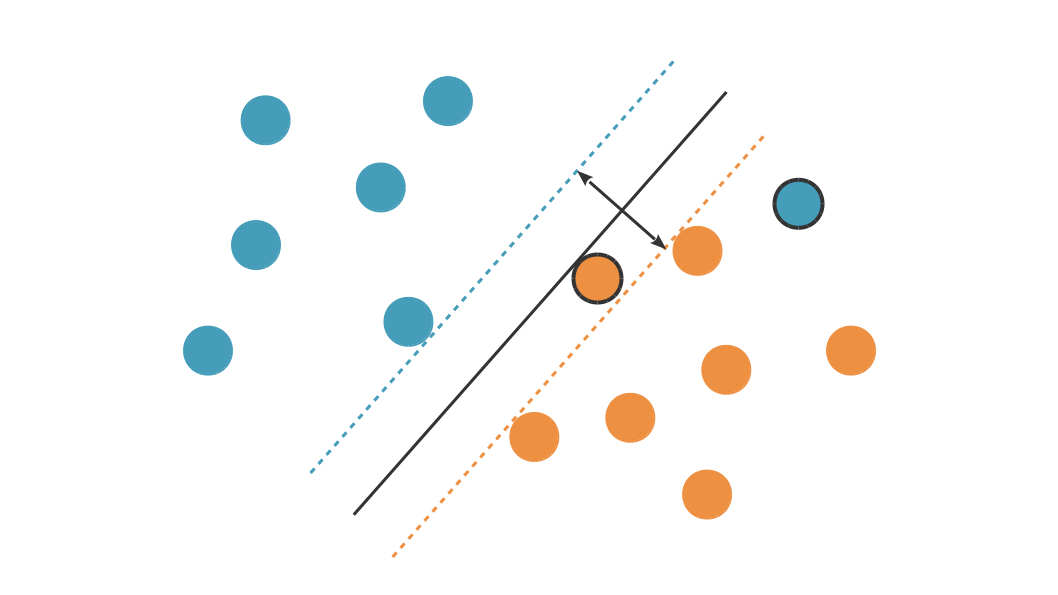
    
    
Plus la marge est grande, plus nous somme susceptibles d'avoir d'erreurs. Nous allons donc devoir <b>minimiser la marge et l'erreur simultanément</b> :

$$\large arg \, {\underset{w \in \mathbb{R}^{p}, b \in \mathbb{R}}{min}} \frac{1}{2} ||w||^2_2 + C \text{ erreur}$$

L'hyperparamètre $\large C$ sert à quantifier l'importance relative du terme d'erreur et du terme de marge.

Il s'agit donc bien d'une <b>régularisation ℓ2</b>, et le coefficient $\large C$ vaut $\large \frac{1}{2\lambda}$ par rapport à ce que nous avons pu écrire pour la régression Ridge.
    
<b>Les SVM peuvent aussi être utilisées pour des problèmes de régression <em>(SVR)</em></b> et on cherche toujours à minimiser $\large ||w||^2_2$ 
</details>

In [24]:
from sklearn.svm import LinearSVR
# Créer un objet modèle de régression linéaire
model = LinearSVR()

# Créer un dictionnaire de paramètres à optimiser
params = {'C': np.logspace(-4, 0, 5),
             'epsilon' : [0, 0.01, 0.1, 0.5, 1, 2],
             'loss' : ["epsilon_insensitive","squared_epsilon_insensitive"],
             'max_iter': [10, 100, 1000]}   

In [25]:
build_model('linearsvr', model, X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)

C:\Users\Fane0763\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


------------------------------------

#### Modèle de regression : linearsvr

------------------------------------

Score  sur le train :  0.5443310553694098
Score  sur le test :  0.4667061563582602


------------------------------------

MAE   : 0.810
MSE   : 1.201
R2    : 0.467
RMSE  : 1.096


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
4,Emission CO2,linearsvr,0.810483,1.201431,0.466706,1.096098,0.034894


### <font color="#337da4" id="3">3. Modèle non-linéaires</font>
[Back to table of content](#-1) <br>

#### <font color="#337da4" id="3.1">3.1. Modèle RandomForestRegressor</font>

<details>
<summary><font color="purple"><b>Explication du modèle</b></font></summary>
<h5>Random Forest</h5>
Les "forêts aléatoires" sont des algorithmes qui se basent sur l'assemblage d'arbre de décision indépendants.

Chaque arbre traitant seulement une partie du problème grâce à un double tirage aléatoire :
<ul>
    <li>Un tirage avec remplacement sur les individus : C'est le <b>tree bagging</b></li>
    <li>Un tirage aléatoire sur les variables : le <b>feature sampling</b></li>
</ul>

Au final, tous ces arbres de décisions indépendants sont assemblés. La prédiction faite par le random forest pour des données inconnues est alors la moyenne de tous les arbres dans le cas de la régression.
    
<h5>Hyperparamètre  : <i>Estimation de max_depth, n_estimators, min_samples_leaf et min_samples_split</i>.</h5>
<ul>
    <li> <i>n_estimators</i> : nombre d’arbres à considérer pour le ramdom forest</li>
    <li> <i>max_depth</i> : nombre maximum de niveaux dans chaque arbre de décision (profondeur) sinon si on ne donne pas de limitation, le processus peut etre long</li>
    <li> <i>min_samples_leaf</i> = nombre minimum d'observations pour créer une feuille (limitation implicite de la profondeur) (limite pour ne pas avoir de feuille trop petite et avoir du sur-apprentissage).</li>
    <li> <i>min_samples_split</i> = nombre minimum d'observations dans un noeud avant la division du noeud</li>
</ul>    
    

[link](https://blent.ai/random-forest-comment-ca-marche/)
    
</details>

In [26]:
from sklearn.ensemble import RandomForestRegressor
# Créer le modèle
model = RandomForestRegressor()

params = {
    'n_estimators' : [10,50,100,200,300,500], # nombre d'arbres de décision
    'max_depth': [1, 5,10,20,30,40,50], # nombre maximum de niveaux dans chaque arbre de décision ,
    'min_samples_leaf' : [1,3,5,10,20,50], # nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt', 'log2'] # nombre de features observées pour chaque arbre
}

In [27]:
build_model('randomforest',model, X_train_CO2, y_train_CO2.values.ravel(), X_test_CO2, y_test_CO2.values.ravel())

------------------------------------

#### Modèle de regression : randomforest

------------------------------------

Score  sur le train :  0.9513340533310499
Score  sur le test :  0.6205328644397508


------------------------------------

MAE   : 0.722
MSE   : 0.855
R2    : 0.621
RMSE  : 0.925


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
5,Emission CO2,randomforest,0.722472,0.854882,0.620533,0.924599,0.555844


#### <font color="#337da4" id="3.2">3.2. Modèle XGBoost *(eXtreme Gradient Boosting)*</font>

<details>
<summary><font color="purple"><b>Explication du modèle </b></font></summary>
<h5>XGBoost</h5>
Comme son nom l'indique, ce modèle est un algorithme de gradient boosting. Ce boosting consiste à assembler plusieurs algorithmes ayant une performance peu élevée pour en créer un beaucoup plus efficace.

Dans le cadre de la régression, les variables à prédire vont être estimées avec un premier modèle, puis les résidus de ce modèle deviendront les variables cible du second modèle, et ainsi de suite.
    
Pour pouvoir prédire un output en fonction d’un input dont on ne connait pas la variable cible, il faut prédire le résidu de chaque modèle et ensuite en faire la somme.
    
Pour l'agorithme XGBoost, réalisé une GridSearch en "brute", en testant toutes les combinaisons est très long et très couteux en temps de calcul. Pour palier à ce problème, nous allons ici utiliser une grille de recherche aléatoire.
</details>

In [28]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

model=xgb.XGBRegressor() # Utilisation du GPU tree_method='gpu_hist'

params = {'learning_rate' : [0.001, 0.01, 0.1, 0.2, 0,3],
             'gamma': [0, 0.25, 0.5, 1.0],
             'max_depth': [6, 10, 15, 20],
             'min_child_weight' : [0.5, 1.0, 3.0, 5.0, 7.0, 10.0],
             'n_estimators': [25, 50, 100, 500]}

In [29]:
build_model('xgboost',model, X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)

------------------------------------

#### Modèle de regression : xgboost

------------------------------------

Score  sur le train :  0.9974691828649659
Score  sur le test :  0.5955125556470535


------------------------------------

MAE   : 0.750
MSE   : 0.911
R2    : 0.596
RMSE  : 0.955


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
6,Emission CO2,xgboost,0.750336,0.911249,0.595513,0.954594,0.115054


#### <font color="#337da4" id="3.3">3.3. Support Vector Regression - SVR NON Linéaire polynomiale</font>


In [30]:
from sklearn.svm import SVR
model = SVR(kernel='poly')

params = {'C': [1, 10, 50, 100], # Paramètre de régulation : pénalité pour les données mal classées. Si C est grand l'algorithme choisira un hyperplan à marge plus faible si cet hyperplan permet de mieux classer tous les points. 
                                                # Si C est petit, l'algorithme choisira un hyperplan à marge plus importante même si cet hyperplan classe plus mal les points
              'epsilon' : [0.01, 0.1, 1], # erreur tolérée par l'algorithme
              'gamma' : [1e-3, 1e-2, 1e-1],    # Kernel coefficient : influence d'une données d'entrainement. gamma faible = donnée a un grand rayons d'influence sur d'autre point pour former une classe. gamma élevé = rayon faible donc les points doivent être proches pour former une classe.
              'degree' : [2,3]}   # degré polynomial

In [31]:
build_model('SVR Poly',model, X_train_CO2, y_train_CO2.values.ravel(), X_test_CO2, y_test_CO2.values.ravel())
model

------------------------------------

#### Modèle de regression : SVR Poly

------------------------------------

Score  sur le train :  0.4894263190885145
Score  sur le test :  -0.06210158599520321


------------------------------------

MAE   : 1.005
MSE   : 2.393
R2    : -0.062
RMSE  : 1.547


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
7,Emission CO2,SVR Poly,1.004841,2.392755,-0.062102,1.546853,0.25083


SVR(kernel='poly')

#### <font color="#337da4" id="3.4">3.4 K-NN regressor </font>

<details>
<summary><font color="purple"><b>Explication du modèle </b></font></summary>

<h4>Définition K-NN</h4> 
    
Le **k-NN** est le diminutif de k Nearest Neighbors. C'est un algorithme qui peut servir autant pour la classification que pour la régression. Il est surnommé « nearest neighbors » (plus proches voisins, en français) car le principe de ce modèle consiste en effet à choisir les k données les plus proches du point étudié afin d'en prédire sa valeur. Le nombre k est un paramètre ajustable.

La méthode KNN est souvent utilisée en apprentissage automatique pour la régression, la classification et la détection d'anomalies. Elle est simple à implémenter et peut être efficace pour les ensembles de données de petite à moyenne taille.
 
    
<h4>Prediction avec K-NN</h4>


- Si K-NN est utilisé pour la régression, c'est la moyenne (ou la médiane) des variables y (y=output variable) des K plus proches observations qui servira pour la prédiction
- Si K-NN est utilisé pour la classification, c'est le mode des variables y des K plus proches observations qui servira pour la prédiction

<h4>Méthodes de calcul de la distance</h4>

Pour le KNN de classification ainsi que de régression, ils ont un paramètre appelé metric qui désigne la méthode de calcul de la distance et qui prend par défaut la valeur ***minkowski***.
    

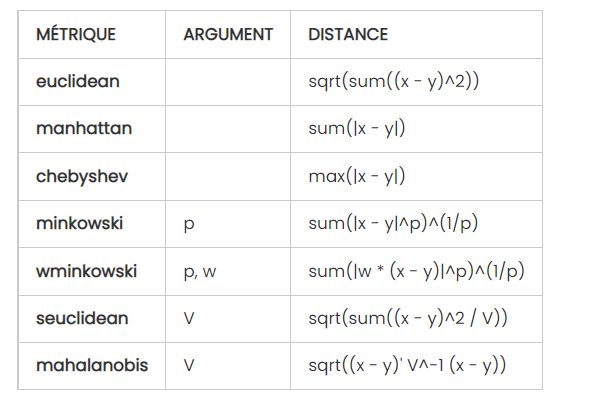
KNN est un algorithme basé sur la distance, les méthodes les plus couramment utilisées étant :<br>
    
> Euclidean et Manhattan pour les données continues <br>
> Distance de Hamming pour les données catégorielles<br>
 
    
La distance euclidienne est la distance mathématique entre deux points dans l'espace euclidien en utilisant la longueur d'une ligne entre les deux points. C'est la mesure de distance la plus connue et beaucoup de gens s'en souviendront de l'école du théorème de Pythagore. 

Manhattan Distance est la distance mathématique entre deux points, qui est la somme de la différence absolue de leurs coordonnées cartésiennes. En termes simples, le mouvement de direction entre la distance ne peut être que supérieur, inférieur et latéral.

La distance de Hamming compare deux chaînes de données binaires, puis compare ces deux entrées de chaîne pour trouver le nombre de caractères différents dans chaque position de la chaîne.
    
<h4>Limitations de K-NN</h4>

K-NN est un algorithme assez simple à appréhender. Principalement, grâce au fait qu'il n'a pas besoin de modèle pour pouvoir effectuer une prédiction. Le contre coût est qu'il doit garder en mémoire l'ensemble des observations pour pouvoir effectuer sa prédiction. Ainsi il faut faire attention à la taille du jeu d'entrainement. 

Egalement, le choix de la méthode de calcul de la distance ainsi que le nombre de voisins K peut ne pas être évident. Il faut essayer plusieurs combinaisons et faire du tuning de l'algorithme pour avoir un résultat satisfaisant.
    
</details>


In [32]:
from sklearn.neighbors import KNeighborsRegressor
# Créer le modèle
model = KNeighborsRegressor()

# Créer un dictionnaire de paramètres à optimiser
params = [{'n_neighbors': np.arange(1, 30, 2), #nombre de voisins
              'weights': ['distance']}] # pondération des plus proches voisins qui auront une plus grande influence que les voisins les plus éloignés.



In [33]:
build_model('knn', model, X_train_CO2, y_train_CO2, X_test_CO2, y_test_CO2)

------------------------------------

#### Modèle de regression : knn

------------------------------------

Score  sur le train :  0.7253187695374625
Score  sur le test :  0.5157499962728084


------------------------------------

MAE   : 0.805
MSE   : 1.091
R2    : 0.516
RMSE  : 1.044


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
8,Emission CO2,knn,0.805327,1.090943,0.51575,1.044482,0.075303


### <font color="#337da4" id="4">4. Selection meilleur modèle </font>  
-----------
[Back to table of content](#-1) <br>

#### <font color="#337da4" id="4.1">4.1. Best model de prédiction des émissions de CO2</font>   

In [34]:
resultats=pd.concat(ListResults,axis=0)
resultats.loc[resultats['ind'].str.contains('co2',na=False,case=False),:].sort_values(by=['R2','RMSE'],ascending=[False,True])

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
5,Emission CO2,randomforest,0.722472,0.854882,0.620533,0.924599,0.555844
6,Emission CO2,xgboost,0.750336,0.911249,0.595513,0.954594,0.115054
8,Emission CO2,knn,0.805327,1.090943,0.515750,1.044482,0.075303
0,Emission CO2,linearregression,0.796248,1.132933,0.497111,1.064393,0.019897
2,Emission CO2,ridge,0.796510,1.133025,0.497070,1.064437,0.031986
4,Emission CO2,linearsvr,0.810483,1.201431,0.466706,1.096098,0.034894
1,Emission CO2,lasso,0.890417,1.352115,0.399820,1.162805,0.028924
3,Emission CO2,elasticnet,1.004934,1.653978,0.265829,1.286071,0.024038
7,Emission CO2,SVR Poly,1.004841,2.392755,-0.062102,1.546853,0.250830


--------
En regardant ces résultats, le modèle **SVR Poly** presente des performances largement en dessous des autres modèles de regression. 
Ce modèle sera éliminé.   
Quant au modèle de regression **RandomForest** presente les meilleures métriques.      
Ce modèle sera retenu comme **meilleur modèle**.

#### <font color="#337da4" id="4.2">4.2. GridSearchCV sur le meilleur modèle </font>

In [35]:
from sklearn.ensemble import RandomForestRegressor
# Re estimation du modèle avec les meilleurs paramètres
model = RandomForestRegressor()

params = {
    'n_estimators' : [10,50,100,200,300,500], # nombre d'arbres de décision
    'max_depth': [1, 5,10,20,30,40,50], # nombre maximum de niveaux dans chaque arbre de décision ,
    'min_samples_leaf' : [1,3,5,10,20,50], # nombre de feuilles minimales dans un noeud
    'max_features': ['auto', 'sqrt', 'log2'] # nombre de features observées pour chaque arbre
}

best_model, best_params=build_model2('best model without ESS',model,params,  X_train_CO2, y_train_CO2.values.ravel(), 
             X_test_CO2, y_test_CO2.values.ravel(),ind='CO2')
best_model
best_params

------------------------------------

#### Modèle de regression : best model without ESS

------------------------------------

Meilleurs paramètres :  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}
Meilleur score test :  0.6502138441376573
Score du modèle sur l'ensemble de test : 0.6480555532430533


------------------------------------

MAE : 0.689
MSE : 0.793
R2 : 0.648
RMSE : 0.890


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
9,Emission CO2,best model without ESS,0.688875,0.792878,0.648056,0.890437,201.014076


{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'n_estimators': 500}

#### <font color="#337da4" id="4.3">4.3. Features importance </font>

--------------------

Le ***feature importance*** ou ***importance des variables*** est une mesure qui permet de quantifier l'importance relative des différentes variables d'entrée (features) dans un modèle de régression aléatoire (random forest). Cette mesure est utile pour comprendre l'impact de chaque variable sur les prédictions du modèle et pour sélectionner les variables les plus importantes.

Le ***Random Forest*** est un algorithme de Machine Learning qui combine plusieurs arbres de décision pour améliorer la précision de la prédiction. L'importance des variables dans un modèle de ***Random Forest*** est calculée en se basant sur la réduction d'erreur moyenne (***Mean Decrease Impurity***) qui est attribuée à chaque variable lors de la construction de chaque arbre de décision.

In [36]:
# best_params={'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'n_estimators': 300}
# best_params=grid.best_params_

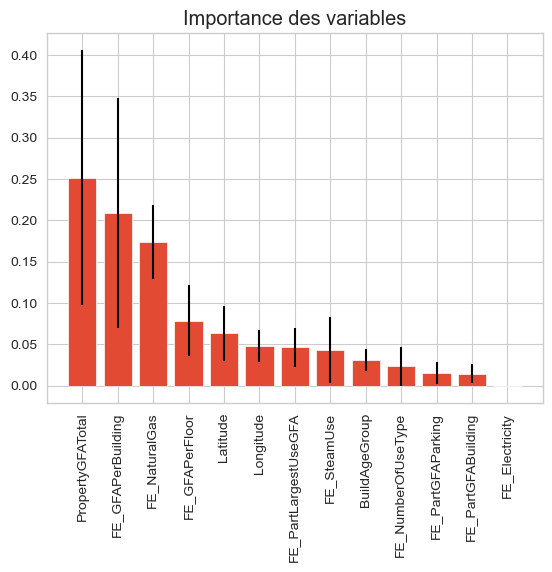

In [37]:
model = best_model # RandomForestRegressor(**best_params)
model

# Entraînement du modèle sur les données d'entraînement
model.fit(X_train_CO2, y_train_CO2.values.ravel())

# Affichage des importances des variables
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Importance des variables")
plt.bar(range(X_train_CO2.shape[1]), importances[indices],  yerr=std[indices], align="center") # color="r",
plt.xticks(range(X_train_CO2.shape[1]), X_train_CO2.columns[indices],rotation=90,size=10)
plt.xlim([-1, X_train_CO2.shape[1]])
plt.show()


-----------
La variable la plus importante est la superficie totale de la proprieté. 
Elle est suivie de la la surface moyenne par Building.

La variable binaire "Utilisation de l'électricité" est la moins importante. 

#### <font color="#337da4" id="4.4">4.4. Analyse des résidus </font>

Les résidus ou  »erreurs observées» sont définis comme étant les différences entre les valeurs observées et les valeurs estimées par un modèle de régression, ils ont la particularité de représenter la partie non expliquée par l’équation de régression.

On les note communément comme suit : $$ e_i =Y_i -\hat{Y}_i $$

L’analyse des résidus a pour objectif de tester la validité d’un modèle de régression. Elle permet de déceler les défaillances d’un modèle, c’est pourquoi il est nécessaire de l’effectuer avant toute analyse de régression.

- Les résidus doivent être normalement distribués.
- Les résidus doivent avoir une variance constante (homoscédasticité).
- Les résidus ne doivent pas avoir de structure (autocorrélation).

In [38]:
import statsmodels.api as sm
# Faites des prédictions sur l'ensemble de test
y_pred = model.predict(X_test_CO2)
y_pred.shape
y_test_CO2.values.ravel()

# Obtenir les résidus du modèle
residuals = y_test_CO2.values.ravel()- y_pred

----------------
Les résidus standards doivent être répartis selon la loi normale. On peut vérifier cela 
1) par des graphiques (histogramme ou QQ-plot) ou 
2) par des tests statistiques (test Shapiro-Wilk ou test de Jarque-Berra).

C:\Users\Fane0763\Anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:1045: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


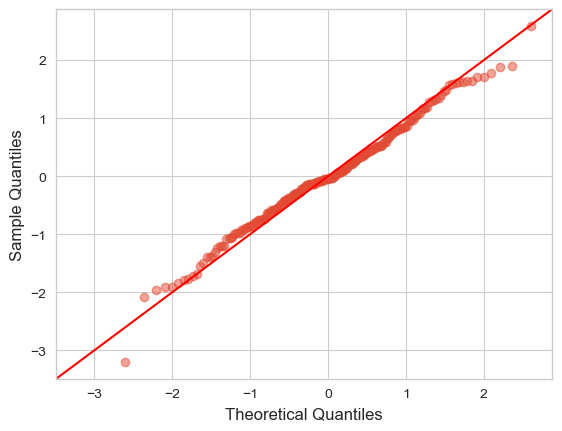

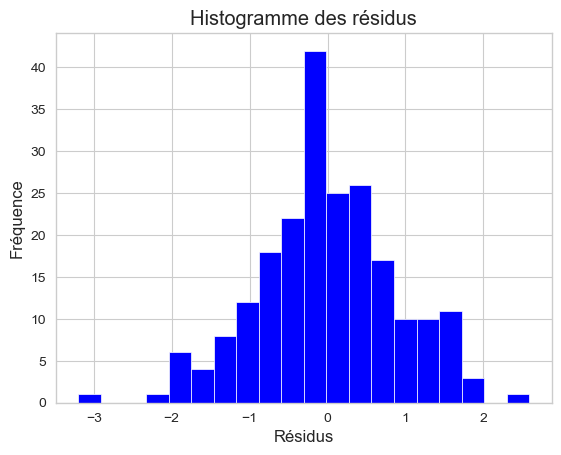

In [39]:
# Vérifier la normalité des résidus avec un graphique Q-Q plot
sm.qqplot(residuals, line='45', alpha=0.5, color='#4C72B0') # line='r',
plt.show()

# import scipy.stats as stats
# fig = sm.qqplot(residuals, stats.t, fit=True,line='45')
# plt.title("QQ plot")
# plt.show()

plt.hist(residuals, bins=20, color='blue')
plt.title('Histogramme des résidus')
plt.xlabel('Résidus')
plt.ylabel('Fréquence')
plt.show()

---------
Le test de Shapiro (qui fonctionne pour les petits échantillons inférieurs à 50) permet de contrôler l'hypothèse nulle d'une répartition normale. 
Si p-value > 0.05 <-> Normalité.

In [40]:
from scipy.stats import shapiro
x, pval = shapiro(residuals) ; print(pval)

0.3697248697280884


Pour les grands échantillons, on peut aussi faire de test de Jarque-Berra :

In [41]:
from scipy.stats import jarque_bera
x, pval = jarque_bera(residuals) ; print(pval)

0.4635013254096466


##### Test de Breusch-Pagan

Cet test renvoie une p-value qui interroge la variance des résidus. Si la p-value est inférieure à 0,05, on doit rejeter la régression comme présentant de l'hétéroscédasticité.

In [42]:
from statsmodels.stats.api import  het_breuschpagan
lagrande, pval, f, fpval = het_breuschpagan(residuals, X_test_CO2)

# Effectuer le test de Breusch-Pagan sur les résidus du modèle de régression random forest
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = sm.stats.diagnostic.het_breuschpagan(residuals, X_test_CO2)

# Afficher les résultats du test de Breusch-Pagan
print('Test de Breusch-Pagan :')
print('Statistique de test :', bp_test[0])
print('P-valeur :', bp_test[1])
print('Valeurs des paramètres :', bp_test[2:])

Test de Breusch-Pagan :
Statistique de test : 39.28030727164864
P-valeur : 9.460706707246466e-05
Valeurs des paramètres : (4.119082577874395, 1.7432901121608818e-05)


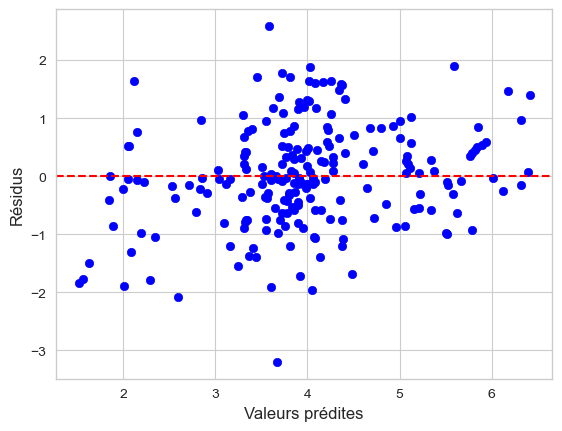

In [43]:
# Vérifier l'homoscédasticité des résidus avec un graphique de dispersion

plt.scatter(y_pred, residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Valeurs prédites')
plt.ylabel('Résidus')
plt.show()

### Vérifier l'autocorrélation des résidus avec un graphique de corrélogramme
Il faut ensuite contrôler l'indépendance des résidus. On peut le faire via :
1) une représentation graphique ACP (auto-correlation function)
2) le test statistique de Durbin-Watson.


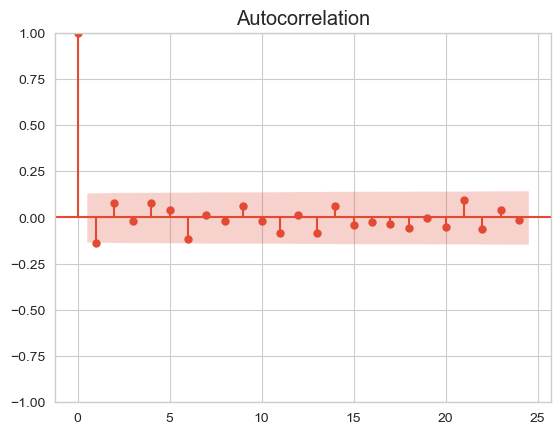

In [44]:
# Vérifier l'autocorrélation des résidus avec un graphique de corrélogramme
sm.graphics.tsa.plot_acf(residuals)
plt.show()
# from statsmodels.graphics.tsaplots import plot_acf
# plot_acf(residuals)

Le test de Durbin-Watson permet de détecter ces autocorrélations par un test objectif. 
La valeur renvoyée doit s'approcher de 2 (**1.6 et 2.4**). Plus elle s'en éloigne, plus on risque d'avoir des autocorrélations.


In [45]:
from statsmodels.stats.stattools import durbin_watson
# Durbin-Watson test
print(durbin_watson(residuals))

2.2677138470947056


### <font color="#337da4" id="5">5. Influence de ENERGY STAR Score</font>
-----------
[Back to table of content](#-1) <br>

Le score **ENERGY STAR Score** fournit un aperçu complet de la performance énergétique d'un bâtiment, en tenant compte des actifs physiques, des opérations et du comportement des occupants du bâtiment. Il est exprimé sur une échelle de 1 à 100 facile à comprendre : **plus le score est élevé, meilleure est la performance énergétique du bâtiment**.

Ce score permet de réaliser plusieurs actions :
- Évaluer les données énergétiques réelles facturées,  
- Normaliser pour l'activité commerciale *(heures, travailleurs, climat)*, 
- Comparer les bâtiments à la population nationale, 
- Indiquer le niveau de performance énergétique.

Tout d'abord, interessons nous à la distribution de cette variable.

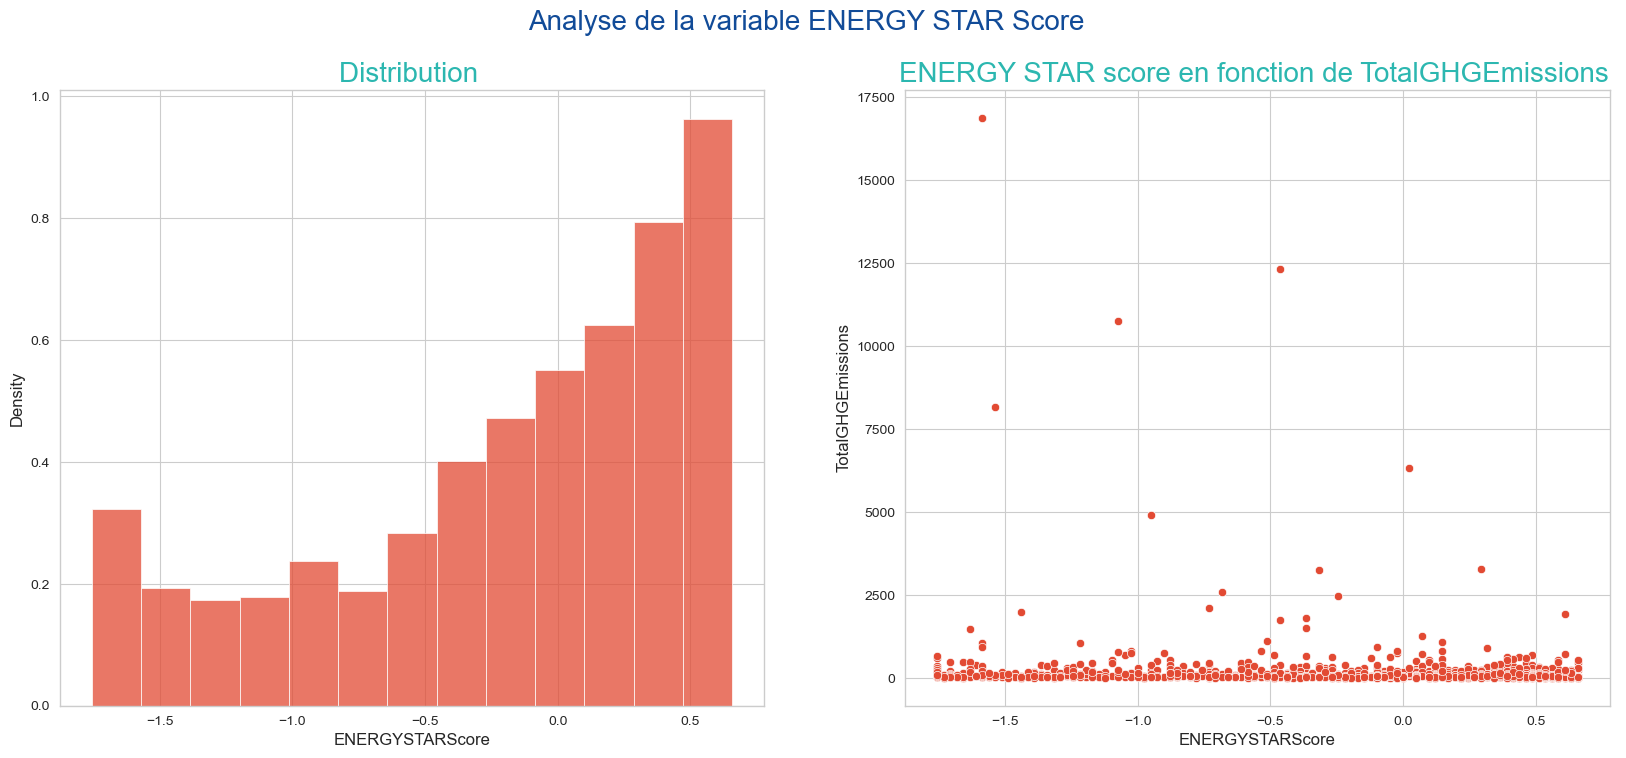

In [46]:
font_title3 = {'family': 'serif', 'color':  '#114b98','weight': 'bold', 'size': 60,}

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.histplot(data=X_CO2, x='ENERGYSTARScore', stat="density", ax=axes[0])
axes[0].set_title("Distribution ", color='#2cb7b0',size=20)
sns.scatterplot(data=dfBuild, y='TotalGHGEmissions', x='ENERGYSTARScore', ax=axes[1])
axes[1].set_title("ENERGY STAR score en fonction de TotalGHGEmissions ", color='#2cb7b0',size=20)
plt.suptitle("Analyse de la variable ENERGY STAR Score \n \n", color='#114b98',size=20)
plt.show()

Nous allons donc évaluer si ce score à un impact significatif sur les performances de notre modélisation.

**Pour ce faire, nous allons utiliser cette variable comme explicative dans notre meilleur modèle.** 

In [47]:
build_model2('best model with ESS',model,params,  X_train_CO2_ESS, y_train_CO2.values.ravel(), 
             X_test_CO2_ESS, y_test_CO2.values.ravel(),ind='CO2')

------------------------------------

#### Modèle de regression : best model with ESS

------------------------------------

Meilleurs paramètres :  {'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 500}
Meilleur score test :  0.7092422195340996
Score du modèle sur l'ensemble de test : 0.7082816832673824


------------------------------------

MAE : 0.651
MSE : 0.657
R2 : 0.708
RMSE : 0.811


------------------------------------

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
10,Emission CO2,best model with ESS,0.651347,0.657198,0.708282,0.810677,220.004897


(RandomForestRegressor(max_depth=10, n_estimators=500),
 {'max_depth': 10,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'n_estimators': 500})

### <font color="#337da4" id="6">6. Conclusion</font>
-----------
[Back to table of content](#-1) <br>

In [48]:
resultats=pd.concat(ListResults,axis=0)
resultats.loc[resultats['Model'].str.contains('best',na=False,case=False),:].sort_values(by=['R2','RMSE'],ascending=[False,True])

,ind,Model,MAE,MSE,R2,RMSE,tempsExecution
10,Emission CO2,best model with ESS,0.651347,0.657198,0.708282,0.810677,220.004897
9,Emission CO2,best model without ESS,0.688875,0.792878,0.648056,0.890437,201.014076


<div class="warning" style="color:#4F6272;font-size:100%;text-align:left;  padding-top: 5px;  padding-left: 5px;  padding-right: 5px; padding-bottom: 10px; margin-bottom: 5px; border-top: solid gray 5px; border-bottom: solid gray 2px;border-radius: 30px 30px;padding-right: 10px;">
<span> 
<p style='margin-left:0.9em;'>
    La variable <b><i> ENERGY STAR Score </i></b> améliore significativement une amélioration de la <b><i>précision du modèle </i></b>; donc, cette variable reste utile pour le calcul de l'emission de CO2. </p>
</span>
</div>